# Time Series Prediction with LSTM Using PyTorch

This kernel is based on *datasets* from

[Time Series Forecasting with the Long Short-Term Memory Network in Python](https://machinelearningmastery.com/time-series-forecasting-long-short-term-memory-network-python/)

[Time Series Prediction with LSTM Recurrent Neural Networks in Python with Keras](https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/)


## Download Dataset

In [ ]:
#!wget https://raw.githubusercontent.com/jbrownlee/Datasets/master/shampoo.csv

In [ ]:
!wget https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv

--2022-04-27 21:28:16--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2180 (2.1K) [text/plain]
Saving to: ‘airline-passengers.csv’

airline-passengers. 100%[===================>]   2.13K  --.-KB/s    in 0s      

2022-04-27 21:28:16 (21.9 MB/s) - ‘airline-passengers.csv’ saved [2180/2180]



## Library

In [169]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler

## Data Plot

In [170]:
energy = pd.read_csv("energyConsumption.csv",index_col='TimeStamp',parse_dates=True)

In [171]:
energy

,EnergyConsumed
TimeStamp,
2018-04-25 12:00:00,3.094930
2018-04-25 13:00:00,3.575657
2018-04-25 14:00:00,3.220890
2018-04-25 15:00:00,12.224048
2018-04-25 16:00:00,36.981414
...,...
2020-02-26 20:00:00,28.527221
2020-02-26 21:00:00,12.749949
2020-02-26 22:00:00,15.502031


In [172]:
energyByDay = {}
for idx, val in energy.iterrows():
    energyByDay[str(idx.date())] = energyByDay.get(str(idx.date()), 0) + val




In [173]:
list(energyByDay.values())[0]

EnergyConsumed    242.365404
dtype: float64

In [174]:
training_set = pd.DataFrame({"TimeStamp" : energyByDay.keys(), "Energy" : energyByDay.values()})

In [175]:
training_set["Energy"] = training_set["Energy"].astype(float)

In [176]:
training_set

,TimeStamp,Energy
0,2018-04-25,242.365404
1,2018-04-26,334.893673
2,2018-04-27,316.421591
3,2018-04-28,299.549053
4,2018-04-29,180.020985
...,...,...
669,2020-02-23,23.178719
670,2020-02-24,153.822359
671,2020-02-25,188.709556
672,2020-02-26,211.407450


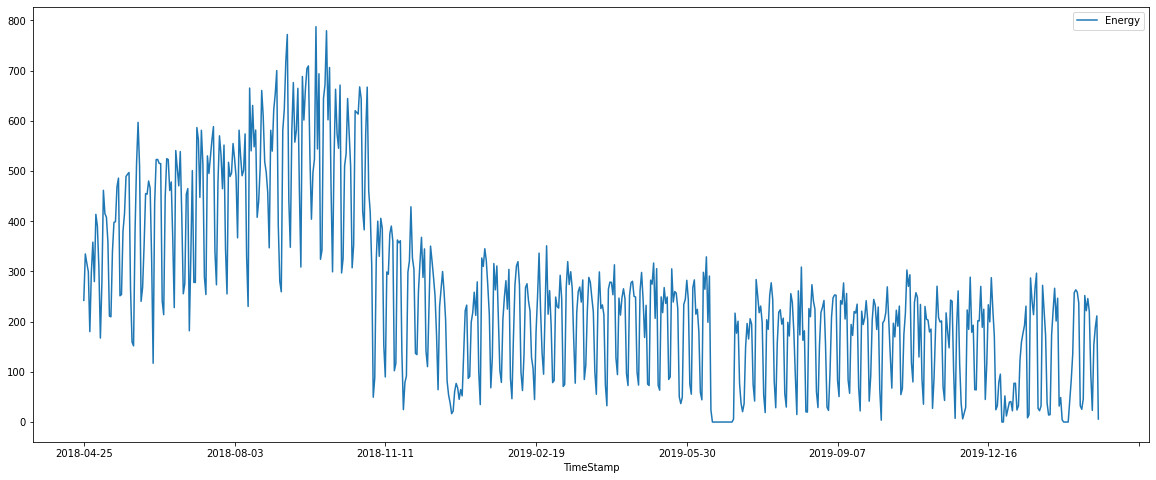

In [177]:
training_set.set_index("TimeStamp").plot(figsize = (20, 8))

In [178]:
training_set = training_set.iloc[:,1:].values

## Dataloading

In [179]:
len(training_set)

674

In [180]:
def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.8)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

In [181]:
dataX

tensor([[[0.3077],
         [0.4252],
         [0.4018],
         [0.3803]],

        [[0.4252],
         [0.4018],
         [0.3803],
         [0.2286]],

        [[0.4018],
         [0.3803],
         [0.2286],
         [0.3774]],

        ...,

        [[0.3124],
         [0.2797],
         [0.1198],
         [0.0294]],

        [[0.2797],
         [0.1198],
         [0.0294],
         [0.1953]],

        [[0.1198],
         [0.0294],
         [0.1953],
         [0.2396]]])

## Model

In [182]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        h_out = h_out.view(-1, self.hidden_size)
        
        out = self.fc(h_out)
        
        return out

## Training

In [183]:
num_epochs = 2000
learning_rate = 0.01

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1

lstm = LSTM(num_classes, input_size, hidden_size, num_layers)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)

# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    
    # obtain the loss function
    loss = criterion(outputs, trainY)
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 0.06603
Epoch: 100, loss: 0.02142
Epoch: 200, loss: 0.01900
Epoch: 300, loss: 0.01738
Epoch: 400, loss: 0.01457
Epoch: 500, loss: 0.01312
Epoch: 600, loss: 0.01300
Epoch: 700, loss: 0.01292
Epoch: 800, loss: 0.01284
Epoch: 900, loss: 0.01275
Epoch: 1000, loss: 0.01268
Epoch: 1100, loss: 0.01261
Epoch: 1200, loss: 0.01255
Epoch: 1300, loss: 0.01248
Epoch: 1400, loss: 0.01242
Epoch: 1500, loss: 0.01236
Epoch: 1600, loss: 0.01230
Epoch: 1700, loss: 0.01225
Epoch: 1800, loss: 0.01220
Epoch: 1900, loss: 0.01216


## Testing for  Dataset

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Unrecognized location 'upper rigth'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  


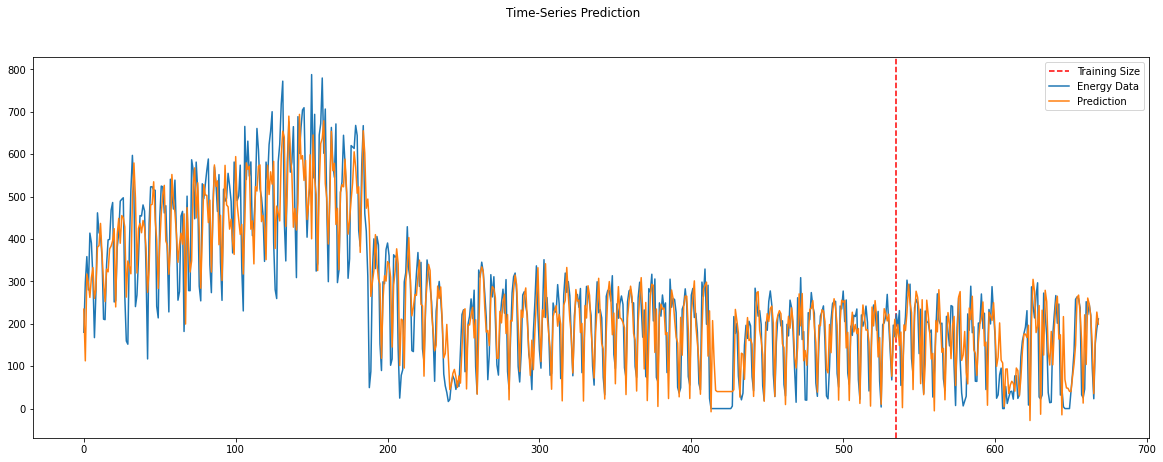

In [191]:
from IPython.core.pylabtools import figsize
lstm.eval()
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

plt.axvline(x=train_size, c='r', linestyle='--', label="Training Size")
plt.plot(dataY_plot, label= "Energy Data")
plt.plot(data_predict, label= "Prediction")
plt.legend(loc="upper rigth")
plt.suptitle('Time-Series Prediction')
plt.show()

In [163]:
len(data_predict), len(dataY_plot)

(669, 669)

In [164]:
data_predict[0][0]

225.98186

In [165]:
predUnpacked = []
for i in data_predict:
  # print(i[0])
  predUnpacked.append(i)

In [166]:
actualUnpacked = []
for i in dataY_plot:
  actualUnpacked.append(i)

In [167]:
from sklearn.metrics import mean_absolute_error

In [192]:
mean_absolute_error(actualUnpacked, predUnpacked) / np.mean(actualUnpacked)

0.26766202